In [ ]:
#Ignore warning in Jupyter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import glob
import sys
import cv2
import os
from os.path import join
import random
from numpy import load
import matplotlib.pyplot as plt
from medpy import metric
import pydicom


In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib
from PIL import Image

# loading Train data

In [ ]:
x_train=load('/home/zaineb/data/x_train-flh.npy',allow_pickle=True)
y_train=load('/home/zaineb/data/y_train-flh.npy',allow_pickle=True)
print(x_train.shape)
print(y_train.shape)

(16, 120, 256, 256, 1)
(16, 120, 256, 256, 2)


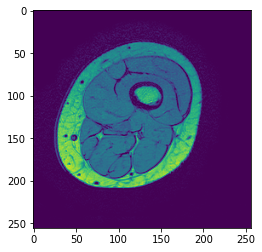

In [ ]:
plt.imshow(x_train[10,50,:,:,0])

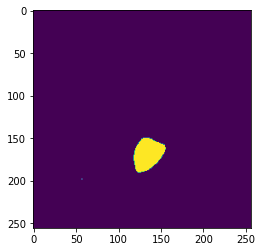

In [ ]:
plt.imshow(y_train[10,50,:,:,0])

In [ ]:
for patient in range(4):
    print(x_train[patient].shape)

(120, 256, 256, 1)
(120, 256, 256, 1)
(120, 256, 256, 1)
(120, 256, 256, 1)


# Graph implmentation 'IFSSNet model'

In [ ]:
import os,time,cv2


import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib import rnn



In [ ]:

def Conv3DBlock(inputs, n_filters, kernel_size=[3, 3, 3], stride = [1,1,1],activation_fn=None):
        """
        Builds the 3d conv block 
        Apply successivly a 3D convolution, BatchNormalization and relu
        """
        # Skip pointwise by setting num_outputs=Non
        net = slim.conv3d(inputs, n_filters, kernel_size=kernel_size,stride=stride, activation_fn=activation_fn)
        net =  slim.layer_norm(net) #slim.batch_norm(net, fused=True)
        net = tf.nn.relu(net)
        return net


# In[ ]:


def Conv3DBlockTranspose(inputs, n_filters, kernel_size=[3, 3, 3], stride = [1,1,1],activation_fn=None):
        """
        Builds the 3d conv transpose block 
        Apply successivly a 3D transpose convolution, BatchNormalization and relu
        """
        # Skip pointwise by setting num_outputs=Non
        net = slim.conv3d_transpose(inputs, n_filters, kernel_size=kernel_size,
                                    stride=stride, activation_fn=activation_fn)
        net =  slim.layer_norm(net) #slim.batch_norm(net, fused=True)
        net = tf.nn.relu(net)
        return net


# In[ ]:


def AtrousSpatialPyramidPoolingModule_3D(inputs, depth=256):
    
    '''
    5D Tensor: batch, time, H, W, C
    '''
    feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.reduce_mean(inputs, [2, 3], keep_dims=True)

    image_features = slim.conv3d(image_features, depth, [1,1,1], activation_fn=None)
  

#     image_features = tf.transpose(tf.stack(list(map(lambda a: 
#                                                     tf.image.resize_bilinear(a, (feature_map_size[2], 
#                                                                                  feature_map_size[3])), 
#                                                     tf.unstack(tf.transpose(image_features,[1,0,2,3,4])))),0),
#                                   [1,0,2,3,4])
    
    image_features = tf.keras.layers.UpSampling3D(size=(1, int(inputs.shape[2]), 
                                                        int(inputs.shape[3])))(image_features)
    
    atrous_pool_block_1 = slim.conv3d(inputs, depth, [1, 1,1], activation_fn=None) # 3x3 filter reciptive field

    atrous_pool_block_6 = slim.conv3d(inputs, depth, [3, 3,3], rate=6, activation_fn=None)# 9x9

    atrous_pool_block_12 = slim.conv3d(inputs, depth, [3, 3,3], rate=12, activation_fn=None)# 15x15

    atrous_pool_block_18 = slim.conv3d(inputs, depth, [3, 3,3], rate=18, activation_fn=None)# 21x21

    net = tf.concat((image_features, atrous_pool_block_1, atrous_pool_block_6, 
                     atrous_pool_block_12, atrous_pool_block_18), axis=-1)

    return net


# In[ ]:


def AtrousSpatialPyramidPoolingModule_3D_rate_9(inputs, depth=256):
    
    '''
    5D Tensor: batch, time, H, W, C
    '''
    feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.reduce_mean(inputs, [2, 3], keep_dims=True)

    image_features = slim.conv3d(image_features, depth, [1,1,1], activation_fn=None)
  

#     image_features = tf.transpose(tf.stack(list(map(lambda a: 
#                                                     tf.image.resize_bilinear(a, (feature_map_size[2], 
#                                                                                  feature_map_size[3])), 
#                                                     tf.unstack(tf.transpose(image_features,[1,0,2,3,4])))),0),
#                                   [1,0,2,3,4])
    
    
    image_features = tf.keras.layers.UpSampling3D(size=(1, int(inputs.shape[2]), 
                                                        int(inputs.shape[3])))(image_features)
    
    
    atrous_pool_block_1 = slim.conv3d(inputs, depth, [1, 1,1], activation_fn=None)# 3x3

    atrous_pool_block_6 = slim.conv3d(inputs, depth, [3, 3,3], rate=2, activation_fn=None)#5x5

    atrous_pool_block_12 = slim.conv3d(inputs, depth, [3, 3,3], rate=4, activation_fn=None)# 7x7

    atrous_pool_block_18 = slim.conv3d(inputs, depth, [3, 3,3], rate=6, activation_fn=None)# 9x9

    net = tf.concat((image_features, atrous_pool_block_1, atrous_pool_block_6, 
                     atrous_pool_block_12, atrous_pool_block_18), axis=-1)

    return net


# In[ ]:


def AtrousSpatialPyramidPoolingModule_3D_rate_11(inputs, depth=256):
    
    '''
    5D Tensor: batch, time, H, W, C
    '''
    feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.reduce_mean(inputs, [2, 3], keep_dims=True)

    image_features = slim.conv3d(image_features, depth, [1,1,1], activation_fn=None)
  

#     image_features = tf.transpose(tf.stack(list(map(lambda a: 
#                                                     tf.image.resize_bilinear(a, (feature_map_size[2], 
#                                                                                  feature_map_size[3])), 
#                                                     tf.unstack(tf.transpose(image_features,[1,0,2,3,4])))),0),
#                                   [1,0,2,3,4])
    
    image_features = tf.keras.layers.UpSampling3D(size=(1, int(inputs.shape[2]), 
                                                        int(inputs.shape[3])))(image_features)
    
    
    atrous_pool_block_1 = slim.conv3d(inputs, depth, [1, 1,1], activation_fn=None)

    atrous_pool_block_6 = slim.conv3d(inputs, depth, [3, 3,3], rate=4, activation_fn=None) #7x7

    atrous_pool_block_12 = slim.conv3d(inputs, depth, [3, 3,3], rate=6, activation_fn=None)# 9x9

    atrous_pool_block_18 = slim.conv3d(inputs, depth, [3, 3,3], rate=8, activation_fn=None)# 11x11

    net = tf.concat((image_features, atrous_pool_block_1, atrous_pool_block_6, 
                     atrous_pool_block_12, atrous_pool_block_18), axis=-1)

    return net


# In[ ]:


def AttentionRefinementModule_3D(inputs, n_filters):
    'for 3d data'
    # 3D Global average pooling
    net = tf.reduce_mean(inputs, [2, 3], keep_dims=True)
    net = slim.conv3d(net, n_filters, kernel_size=[1,1,1])
    net = slim.layer_norm(net)
    #net = slim.batch_norm(net, fused=True)
    net = tf.sigmoid(net)
    net = tf.multiply(inputs, net)
    return net


# In[ ]:


def FeatureFusionModule(input_1, input_2, n_filters):
    
    inputs = tf.concat([input_1, input_2], axis=-1)
    inputs =Conv3DBlock(inputs, n_filters, kernel_size=[3, 3, 3], stride = [1,1,1],activation_fn=None)
    

    # Global average pooling
    net = tf.reduce_mean(inputs, [2, 3], keep_dims=True)
    
    net = slim.conv3d(net, n_filters, kernel_size=[1,1,1])
    net = tf.nn.relu(net)
    
    net = slim.conv3d(net, n_filters, kernel_size=[1,1,1])
    net = tf.sigmoid(net)

    net = tf.multiply(inputs, net)

    net = tf.add(inputs, net)
    return net


# In[ ]:


def FeatureFusionModule_with_Stirde(input_1, input_2, n_filters):
    
    inputs = tf.concat([input_1, input_2], axis=-1)
    inputs =Conv3DBlock(inputs, n_filters, kernel_size=[3, 3, 3], stride = [1,2,2],activation_fn=None)
    

    # Global average pooling
    net = tf.reduce_mean(inputs, [2, 3], keep_dims=True)
    
    net = slim.conv3d(net, n_filters, kernel_size=[1,1,1])
    net = tf.nn.relu(net)
    
    net = slim.conv3d(net, n_filters, kernel_size=[1,1,1])
    net = tf.sigmoid(net)

    net = tf.multiply(inputs, net)

    net = tf.add(inputs, net)
    return net


# In[ ]:


def Tversky_sigmoid(prediction,ground_truth,alpha = 0.25, axis=(1, 2, 3,4)):
    '''
    prediction is the probabilities from sigmoid. Only one channel is provided and backgorund is estimated
    '''
    
    P_foreground = prediction
    P_background = 1-prediction

    g_foreground = ground_truth
    g_background = 1-ground_truth

    true_positive = tf.reduce_sum(P_foreground * g_foreground, axis=axis)
    false_pos = tf.reduce_sum(P_foreground * g_background, axis=axis)
    false_neg = tf.reduce_sum(P_background * g_foreground, axis=axis)

    Tversky = tf.divide(true_positive+smooth, 
                       true_positive + (alpha*false_pos) + ((1-alpha)*false_neg) + smooth)

    return 1-tf.reduce_mean(Tversky)


def focal_tversky_sigmoid(prediction,ground_truth,alpha):
    Tversly_loss = Tversky_sigmoid(prediction,ground_truth,alpha)
    gamma = 2
    return tf.pow(-tf.math.log(Tversly_loss), gamma)


def Tversky_softmax(prediction,ground_truth,keep_prob_tp,keep_prob_alpha,keep_prob_beta, axis=(1, 2, 3,4)):
    '''
    prediction is the probabilities from softmax
    '''    
    smooth=1
    P_foreground = prediction[...,:1]
    P_background = prediction[...,1:]
    g_foreground = ground_truth[...,:1]
    g_background = ground_truth[...,1:]

    P_foreground = tf.nn.dropout(P_foreground,keep_prob_tp,name="P_foreground_drop_out")
    #g_foreground = tf.nn.dropout(g_foreground,keep_prob_tp,name="g_foreground_drop_out")

    #P_background = tf.nn.dropout(P_background,keep_prob_tp,name="P_background_drop_out")
    #g_background = tf.nn.dropout(g_background,keep_prob_tp,name="g_background_drop_out")
   
    true_positive= P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)
   
    false_pos = P_foreground * g_background
    false_pos = keep_prob_alpha*tf.reduce_sum(false_pos, axis=axis)
    
    
    false_neg = P_background * g_foreground
    false_neg = keep_prob_beta*tf.reduce_sum(false_neg, axis=axis)
    
    Tversky = tf.divide(true_positive+smooth, 
                        (true_positive + false_pos + false_neg + smooth))
    
    return tf.reduce_mean(Tversky) 

def focal_tversky_softmax(prediction,ground_truth,keep_prob_tp,keep_prob_alpha,keep_prob_beta):
    Tversly_loss = Tversky_softmax(prediction,ground_truth,keep_prob_tp,keep_prob_alpha,keep_prob_beta)
    gamma = 2
    return tf.pow(1-Tversly_loss, gamma)


# In[ ]:


def Tversky_Index(prediction,ground_truth,axis=(1, 2, 3,4)):
    '''
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta 
    '''    
    smooth=1
    P_foreground = prediction[...,:1]
    P_background = prediction[...,1:]
    g_foreground = ground_truth[...,:1]
    g_background = ground_truth[...,1:]

   
    true_positive= P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)
   
    false_pos = P_foreground * g_background
    false_pos = 0.5*tf.reduce_sum(false_pos, axis=axis)
    
    
    false_neg = P_background * g_foreground
    false_neg = 0.5*tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(true_positive+smooth, 
                        (true_positive + false_pos + false_neg + smooth))
    
    return tf.reduce_mean(Tversky) 


# In[ ]:


def dice_coe(output, target, loss_type='sorensen', axis=(1, 2, 3,4), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice   


# In[ ]:


def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3,4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity 
    """
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
    # old axis=[0,1,2,3]
    # epsilon = 1e-5
    # batch_iou = inse / (union + epsilon)
    # new haodong
    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name='iou_coe')
    return iou  # , pre, truth, inse, union


# In[ ]:


def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3,4), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity
    """
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    hard_dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name='hard_dice')
    return hard_dice


# In[ ]:


K = tf.keras.backend

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall


# In[ ]:


def Downsampling_2D(inputs,scale1,scale2):
    return tf.image.resize_bilinear(inputs, size=[scale1,scale2])

def Down_sample_3D(input_layer,scale1,scale2):
    '''
    TODO : 10 should be changed to new time scale 10 30 or 200 
    '''
    unpol_layer = list(map(lambda layer: Downsampling_2D(layer,scale1,scale2), tf.unstack(input_layer, 
                                                                                  int(input_layer.get_shape()[1]), 
                                                                                  1)))
    return tf.transpose(tf.stack(unpol_layer),[1,0,2,3,4])


# In[ ]:


def skip(layer, end_point): return tf.concat([layer, end_point], axis=4)
def unpool(layer): return tf.image.resize_nearest_neighbor(layer, 
                                                           [2*int(layer.get_shape()[1]), 
                                                            2*int(layer.get_shape()[2])])
# unpool based on 2D data
def unpool_3D_2(input_layer):
    unpol_layer = list(map(lambda layer: unpool(layer), tf.unstack(input_layer, 
                                                                   int(input_layer.get_shape()[1]), 1)))
    return tf.transpose(tf.stack(unpol_layer),[1,0,2,3,4])


def unpool_3D(input_layer):
    
    unpol_layer = tf.keras.layers.UpSampling3D(size=(1, 2,2))(input_layer)
    return unpol_layer


# In[ ]:


# Re-define for 5D Tensor, here we are dealing with 5D: axis=3 become axis=4 last channel
def pixel_wise_softmax(output_map):
    return tf.nn.softmax(output_map)


# In[ ]:


from tensorflow.contrib.layers.python.layers import initializers
def weight_variable(shape):
    weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True,seed=None,dtype=tf.float32)
    Weight = tf.Variable(weights_initializer(shape=shape))    
    return Weight


# In[ ]:


def weight_variable2(shape):
    weights_initializer=tf.random_uniform_initializer(minval=0.5, maxval=0.5, seed=None)
    Weight = tf.Variable(weights_initializer(shape=shape))    
    return Weight


In [ ]:
tf.reset_default_graph()

In [ ]:
time_step = None # whatever the depth of the volume, we use a sliding window of T
H=256
W=256
C = 1 # number of input channels
num_classes = 2 # related to SOlm GL and GM
n_class = 2

Define placeholder for data


In [ ]:
# define the input stracture: 5D Tensor

x = tf.placeholder("float", shape=[None,time_step, H, W, C ], name="x")
y = tf.placeholder("float", shape=[None,time_step,H, W,num_classes], name="y")



x_target = tf.placeholder("float", shape=[None,time_step, H, W, C ], name="x_target")
x_ref = tf.placeholder("float", shape=[None,time_step, H, W, C ], name="x_ref")


y_reference = tf.placeholder("float", shape=[None,time_step,H, W,num_classes], name="y_reference")
y_estimated = tf.placeholder("float", shape=[None,time_step,H, W,num_classes], name="y_estimated")

# define the placeholder for dropout
keep_prob = tf.placeholder(tf.float32, name="dropout_probability")
keep_prob_input = tf.placeholder(tf.float32, name="dropout_probability_input")
keep_prob_skip = tf.placeholder(dtype=tf.float32,name='SkipDropout')

print('Input Structure: ',x)
print('Target Structure: ',y)

Input Structure:  Tensor("x:0", shape=(?, ?, 256, 256, 1), dtype=float32)
Target Structure:  Tensor("y:0", shape=(?, ?, 256, 256, 2), dtype=float32)


In [ ]:
def compute_mean_iou(pred, label):

    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels);

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)

    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))
    mean_iou = np.mean(I / U)
    return mean_iou

In [ ]:
keep_prob_alpha = tf.placeholder(tf.float32, name="drop_alpha")
keep_prob_beta = tf.placeholder(tf.float32, name="drop_beta")
keep_prob_tp = tf.placeholder(tf.float32, name="drop_tp")

In [ ]:
# defined as variables ?
Batch_size = tf.shape(x)[0]
time_size = tf.shape(x)[1]

# # Bi-directional spatio-temporal smoothness and Interactive


In [ ]:
# # Bi-directional spatio-temporal smoothness and Interactive

reuseflagEncoder_target = False # to train flag must be set to zero

with slim.arg_scope([slim.conv3d],
                    padding='SAME', 
                    normalizer_fn=None, #slim.layer_norm
                    normalizer_params=None,
                    weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True,seed=None,dtype=tf.float32), #tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG'), 
                    weights_regularizer=tf.contrib.layers.l2_regularizer(1e-4),
                    biases_initializer=None,
                    activation_fn=None) as Encoder_scp:
    
    ################# Layer 1
    # conv3d
    
    with tf.variable_scope("layer_1",reuse=reuseflagEncoder_target) as scope:
        
        Layer_1 = Conv3DBlock(x_target, 30, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_1 = tf.nn.max_pool3d(Layer_1, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_1p')

        Layer_1 = AtrousSpatialPyramidPoolingModule_3D(Layer_1, depth=6)
        print(Layer_1)
        #Layer_1 = Conv3DBlock(Layer_1, 16, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        #print(Layer_1)
        Layer_1 =  tf.nn.dropout(Layer_1,keep_prob_skip)
        print(Layer_1)


    # Conv3d
    with tf.variable_scope("layer_2",reuse=reuseflagEncoder_target) as scope:

        Layer_2 = Conv3DBlock(Layer_1, 30, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_2 = tf.nn.max_pool3d(Layer_2, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_2p')
            
        print(Layer_2)
        Layer_2 = AtrousSpatialPyramidPoolingModule_3D(Layer_2, depth=6)
        print(Layer_2)
        Layer_2 =  tf.nn.dropout(Layer_2,keep_prob_skip)
        print(Layer_2)
    

    with tf.variable_scope("layer_3",reuse=reuseflagEncoder_target) as scope:

        Layer_3 = Conv3DBlock(Layer_2, 60, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_3 = tf.nn.max_pool3d(Layer_3, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_3p')
        print(Layer_3)
        
        Layer_3 = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3, depth=12)
        print(Layer_3)
        Layer_3 =  tf.nn.dropout(Layer_3,keep_prob_skip)
        print(Layer_3)

    with tf.variable_scope("layer_4",reuse=reuseflagEncoder_target) as scope:
        Layer_4 = Conv3DBlock(Layer_3, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_4 = tf.nn.max_pool3d(Layer_4, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_4p')
        print(Layer_4)
        Layer_4 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4, depth=24)
        print(Layer_4)
        Layer_4 =  tf.nn.dropout(Layer_4,keep_prob_skip)
        print(Layer_4)
    
    with tf.variable_scope("layer_5",reuse=reuseflagEncoder_target) as scope:
        Layer_5 = Conv3DBlock(Layer_4, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_5 = tf.nn.max_pool3d(Layer_5, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_5p')
        Layer_5 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5, depth=24)
        print(Layer_5)

Instructions for updating:
Please use `layer.__call__` method instead.
Tensor("layer_1/concat:0", shape=(?, ?, 128, 128, 30), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("layer_1/dropout/mul_1:0", shape=(?, ?, 128, 128, 30), dtype=float32)
Tensor("layer_2/Layer_2p:0", shape=(?, ?, 64, 64, 30), dtype=float32)
Tensor("layer_2/concat:0", shape=(?, ?, 64, 64, 30), dtype=float32)
Tensor("layer_2/dropout/mul_1:0", shape=(?, ?, 64, 64, 30), dtype=float32)
Tensor("layer_3/Layer_3p:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_3/concat:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_3/dropout/mul_1:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_4/Layer_4p:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_4/concat:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_4/dropout/mul_1:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_5/concat:0"

# # Encoder Stream for Estimated Predictions (reuse features from x)


In [ ]:
# # Encoder Stream for Estimated Predictions (reuse features from x)

# In[29]:


reuseflagEncoder_target = True # to train flag must be set to zero

with slim.arg_scope([slim.conv3d],
                    padding='SAME', 
                    normalizer_fn=None, #slim.layer_norm
                    normalizer_params=None,
                    weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True,seed=None,dtype=tf.float32), #tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG'), 
                    weights_regularizer=tf.contrib.layers.l2_regularizer(1e-4),
                    biases_initializer=None,
                    activation_fn=None) as Encoder_scp:
    
    ################# Layer 1
    # conv3d
    
    with tf.variable_scope("layer_1",reuse=reuseflagEncoder_target) as scope:
        
        Layer_1y = Conv3DBlock(y_estimated[:,:,:,:,:1], 30, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_1y = tf.nn.max_pool3d(Layer_1y, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_1p')

        Layer_1y = AtrousSpatialPyramidPoolingModule_3D(Layer_1y, depth=6)
        print(Layer_1y)
        #Layer_1 = Conv3DBlock(Layer_1, 16, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        #print(Layer_1)
        Layer_1y =  tf.nn.dropout(Layer_1y,keep_prob_skip)
        print(Layer_1y)


    # Conv3d
    with tf.variable_scope("layer_2",reuse=reuseflagEncoder_target) as scope:

        Layer_2y = Conv3DBlock(Layer_1y, 30, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_2y = tf.nn.max_pool3d(Layer_2y, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_2p')
            
        print(Layer_2y)
        Layer_2y = AtrousSpatialPyramidPoolingModule_3D(Layer_2y, depth=6)
        print(Layer_2y)
        Layer_2y =  tf.nn.dropout(Layer_2y,keep_prob_skip)
        print(Layer_2y)
    

    with tf.variable_scope("layer_3",reuse=reuseflagEncoder_target) as scope:

        Layer_3y = Conv3DBlock(Layer_2y, 60, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_3y = tf.nn.max_pool3d(Layer_3y, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_3p')
        print(Layer_3y)
        
        Layer_3y = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3y, depth=12)
        print(Layer_3y)
        Layer_3y =  tf.nn.dropout(Layer_3y,keep_prob_skip)
        print(Layer_3y)

    with tf.variable_scope("layer_4",reuse=reuseflagEncoder_target) as scope:
        Layer_4y = Conv3DBlock(Layer_3y, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_4y = tf.nn.max_pool3d(Layer_4y, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_4p')
        print(Layer_4y)
        Layer_4y = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4y, depth=24)
        print(Layer_4y)
        Layer_4y =  tf.nn.dropout(Layer_4y,keep_prob_skip)
        print(Layer_4y)
    
    with tf.variable_scope("layer_5",reuse=reuseflagEncoder_target) as scope:
        Layer_5y = Conv3DBlock(Layer_4y, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        Layer_5y = tf.nn.max_pool3d(Layer_5y, strides=[1, 1, 2, 2, 1], 
                                        ksize=[1, 3, 3, 3, 1], padding='SAME', name='Layer_5p')
        Layer_5y = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5y, depth=24)
        print(Layer_5y)



Tensor("layer_1_1/concat:0", shape=(?, ?, 128, 128, 30), dtype=float32)
Tensor("layer_1_1/dropout/mul_1:0", shape=(?, ?, 128, 128, 30), dtype=float32)
Tensor("layer_2_1/Layer_2p:0", shape=(?, ?, 64, 64, 30), dtype=float32)
Tensor("layer_2_1/concat:0", shape=(?, ?, 64, 64, 30), dtype=float32)
Tensor("layer_2_1/dropout/mul_1:0", shape=(?, ?, 64, 64, 30), dtype=float32)
Tensor("layer_3_1/Layer_3p:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_3_1/concat:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_3_1/dropout/mul_1:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_4_1/Layer_4p:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_4_1/concat:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_4_1/dropout/mul_1:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_5_1/concat:0", shape=(?, ?, 8, 8, 120), dtype=float32)


# # Fusion and SpatioTemporal Correlations


In [ ]:
# # Fusion and SpatioTemporal Correlations

ConvLSTM2D = tf.keras.layers.ConvLSTM2D 



reuseflag_Temporal_target_y = False # to train flag must be set to zero
with tf.variable_scope("Temporal",reuse=reuseflag_Temporal_target_y) as scope:
    
    Fused_x_y = FeatureFusionModule(Layer_5, Layer_5y, 120)
        
    BiSpatioTemporal_x_y = ConvLSTM2D(filters = 120, kernel_size=(1, 1), padding='same', return_sequences = True, 
                        go_backwards =False,kernel_initializer = 'he_normal',
                          recurrent_dropout=0.3,activation=tf.nn.tanh)(Fused_x_y)
    print(BiSpatioTemporal_x_y)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("Temporal/conv_lst_m2d/transpose_1:0", shape=(?, ?, 8, 8, 120), dtype=float32)


# DEcoder

In [ ]:
# # Build the Decoder

# Do not reuse the features, train them
reuseflagDecoder = False

# Building the Decoder Layers
with slim.arg_scope([slim.conv3d_transpose],
                    padding='SAME',
                    normalizer_fn=None,
                    normalizer_params={'scale': False},
                    weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True,
                                                                             seed=None,
                                                                             dtype=tf.float32),#tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG'), 
                    weights_regularizer=tf.contrib.layers.l2_regularizer(1e-4),
                    biases_initializer=None,
                    activation_fn=None) as Decoder_scp:
    
    with tf.variable_scope("layer_6",reuse=reuseflagDecoder) as scope:
        Layer_6 = Conv3DBlockTranspose(BiSpatioTemporal_x_y,
                                       120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_6)
        Layer_6 = Conv3DBlock(Layer_6, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_6)
        Layer_6 =FeatureFusionModule(input_1=Layer_6,
                                input_2=BiSpatioTemporal_x_y, 
                                n_filters=120)
        print(Layer_6)
        Layer_6 = unpool_3D(Layer_6)
        Layer_6 =  tf.nn.dropout(Layer_6,keep_prob_skip)
        print(Layer_6)
        
    with tf.variable_scope("layer_7",reuse=reuseflagDecoder) as scope:
        Layer_7 = Conv3DBlockTranspose(Layer_6, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_7)
    
        Layer_7 = Conv3DBlock(Layer_7, 120, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_7)
        Layer_7 = FeatureFusionModule(input_1=Layer_7,
                                input_2=Layer_4, 
                                n_filters=120)
        print(Layer_7)
        Layer_7 = unpool_3D(Layer_7)
        
        Layer_7 =  tf.nn.dropout(Layer_7,keep_prob_skip)
        print(Layer_7)
        
    with tf.variable_scope("layer_8",reuse=reuseflagDecoder) as scope:
        Layer_8 = Conv3DBlockTranspose(Layer_7, 60, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_8)
        Layer_8 = Conv3DBlock(Layer_8, 60, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_8)
        Layer_8 = FeatureFusionModule(input_1=Layer_8,
                                input_2=Layer_3, 
                                n_filters=60)
        print(Layer_8)
        Layer_8 = unpool_3D(Layer_8)
        Layer_8 =  tf.nn.dropout(Layer_8,keep_prob_skip)
        print(Layer_8)

    with tf.variable_scope("layer_9",reuse=reuseflagDecoder) as scope:
        Layer_9= Conv3DBlockTranspose(Layer_8, 60, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_9)
        Layer_9 = Conv3DBlock(Layer_9, 60, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_9)
        Layer_9 = FeatureFusionModule(input_1=Layer_9,
                                input_2=Layer_2, 
                                n_filters=60)
        print(Layer_9)
        Layer_9 = unpool_3D(Layer_9)
        Layer_9 =  tf.nn.dropout(Layer_9,keep_prob_skip)
        print(Layer_9)

    with tf.variable_scope("layer_10",reuse=reuseflagDecoder) as scope:
        Layer_10= Conv3DBlockTranspose(Layer_9, 16, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_10)
        Layer_10 = Conv3DBlock(Layer_10, 16, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_10)
        Layer_10 = FeatureFusionModule(input_1=Layer_10,
                                input_2=Layer_1, 
                                n_filters=16)
        Layer_10 = unpool_3D(Layer_10)
        Layer_10 =  tf.nn.dropout(Layer_10,keep_prob_skip)
        print(Layer_10) 
        

    with tf.variable_scope("layer_11",reuse=reuseflagDecoder) as scope:
        Layer_11= Conv3DBlockTranspose(Layer_10, 8, kernel_size=[3,3,3], stride = [1,1,1],activation_fn=None)
        print(Layer_11)
        Layer_11 = Conv3DBlock(Layer_11, 8, kernel_size=[1,1,1], stride = [1,1,1],activation_fn=None)
        print(Layer_11)
        #Layer_11 = unpool_3D(Layer_11)
        Layer_11 =  tf.nn.dropout(Layer_11,keep_prob_skip)
        print(Layer_11) 



Tensor("layer_6/Relu:0", shape=(?, ?, 8, 8, 120), dtype=float32)
Tensor("layer_6/Relu_1:0", shape=(?, ?, 8, 8, 120), dtype=float32)
Tensor("layer_6/Add:0", shape=(?, ?, 8, 8, 120), dtype=float32)
Tensor("layer_6/dropout/mul_1:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_7/Relu:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_7/Relu_1:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_7/Add:0", shape=(?, ?, 16, 16, 120), dtype=float32)
Tensor("layer_7/dropout/mul_1:0", shape=(?, ?, 32, 32, 120), dtype=float32)
Tensor("layer_8/Relu:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_8/Relu_1:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_8/Add:0", shape=(?, ?, 32, 32, 60), dtype=float32)
Tensor("layer_8/dropout/mul_1:0", shape=(?, ?, 64, 64, 60), dtype=float32)
Tensor("layer_9/Relu:0", shape=(?, ?, 64, 64, 60), dtype=float32)
Tensor("layer_9/Relu_1:0", shape=(?, ?, 64, 64, 60), dtype=float32)
Tensor("layer_9/Add:0", shape=(?, ?, 64, 6

In [ ]:
# Output Map for mask
reuseflagOutputMap = False

with slim.arg_scope([slim.conv3d_transpose],
                    padding='SAME',
                    normalizer_fn=None,
                    normalizer_params={'scale': False},
                    weights_initializer=tf.contrib.layers.xavier_initializer(uniform=True,
                                                                             seed=None,
                                                                             dtype=tf.float32),#tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG'), 
                    weights_regularizer=tf.contrib.layers.l2_regularizer(1e-4),
                    biases_initializer=None,
                    activation_fn=None)as output_scp:

    
    with tf.variable_scope("layer_output",reuse=reuseflagOutputMap) as scope:
        net_output_256_logits = slim.conv3d(Layer_11, num_classes, [1,1,1], 
                                                activation_fn=tf.nn.relu, scope='output_map')
        print(net_output_256_logits)

Tensor("layer_output/output_map/Relu:0", shape=(?, ?, 256, 256, 2), dtype=float32)


In [ ]:

reuseflagOutputHM= False
with tf.variable_scope("output",reuse=reuseflagOutputHM) as scope:
    net_output_256 = pixel_wise_softmax(net_output_256_logits)
    print(net_output_256)


Tensor("output/Softmax:0", shape=(?, ?, 256, 256, 2), dtype=float32)


# LOss function and metrics

In [ ]:

# # Define the Loss based on Tversky Index and Learned Alpha and Beta

# # compare with pseduo Code which is our previous estimation

smooth=1
# Current Prediction
P_foreground_SOL = net_output_256[...,:1]
P_background_SOL  = net_output_256[...,1:]
# Reference or previously estimated tensor
g_foreground_SOL  = y_estimated[...,:1]
g_background_SOL  = y_estimated[...,1:]
print(P_foreground_SOL)
print(P_background_SOL)

Tensor("strided_slice_2:0", shape=(?, ?, 256, 256, 1), dtype=float32)
Tensor("strided_slice_3:0", shape=(?, ?, 256, 256, 1), dtype=float32)


In [ ]:

# # Compute the TP, FP, and FN for each Muscle

true_positive_SOL= P_foreground_SOL * g_foreground_SOL
P_foreground_SOL = tf.nn.dropout(P_foreground_SOL,keep_prob_tp,name="P_foreground_drop_out_SOL")

false_pos_SOL = P_foreground_SOL * g_background_SOL
false_neg_SOL = P_background_SOL * g_foreground_SOL

print(true_positive_SOL)
print(false_pos_SOL)
print(false_neg_SOL)


Tensor("mul:0", shape=(?, ?, 256, 256, 1), dtype=float32)
Tensor("mul_1:0", shape=(?, ?, 256, 256, 1), dtype=float32)
Tensor("mul_2:0", shape=(?, ?, 256, 256, 1), dtype=float32)


In [ ]:
def weight_variable2(shape):
    weights_initializer=tf.random_uniform_initializer(minval=0.5, maxval=0.5, seed=None)
    Weight = tf.Variable(weights_initializer(shape=shape))    
    return Weight

In [ ]:
# # Penealise the FP and the FN by learned alpha and beta
true_positive_SOL=tf.reduce_sum(tf.reduce_sum(true_positive_SOL, axis=(2,3,4)),axis=(1))
false_pos_SOL=tf.reduce_sum(0.2*tf.reduce_sum(false_pos_SOL, axis=(2,3,4)),axis=(1))
false_neg_SOL=tf.reduce_sum(0.8*tf.reduce_sum(false_neg_SOL, axis=(2,3,4)),axis=(1))
print(true_positive_SOL)
print(false_pos_SOL)
print(false_neg_SOL)

Tensor("Sum_1:0", shape=(?,), dtype=float32)
Tensor("Sum_3:0", shape=(?,), dtype=float32)
Tensor("Sum_5:0", shape=(?,), dtype=float32)


In [ ]:
# # Compute Tversky Index for each of the muscle
TverskyIndex_SOL = tf.divide(true_positive_SOL+smooth, (true_positive_SOL + false_pos_SOL  + false_neg_SOL  + smooth))
print(TverskyIndex_SOL)    


Tensor("truediv:0", shape=(?,), dtype=float32)


In [ ]:
with tf.name_scope("loss"):
    dice_loss_SOL = 1-tf.reduce_mean(TverskyIndex_SOL)
print(dice_loss_SOL)


Tensor("loss/sub:0", shape=(), dtype=float32)


In [ ]:
# Schaduale Learning rate
global_step = tf.Variable(0, trainable=False)
boundaries = [19000]
values = [0.0001,0.00001]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)


In [ ]:

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(dice_loss_SOL,global_step=global_step)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Compute Dice Value
IoU_SOL = iou_coe(net_output_256,y)      
print(IoU_SOL)


Tensor("iou_coe:0", shape=(), dtype=float32)


In [ ]:

# Compute Dice Value
TverskyIndexValue_SOL = Tversky_Index(net_output_256,y)      
print(TverskyIndexValue_SOL)


Tensor("Mean:0", shape=(), dtype=float32)


In [ ]:
with tf.name_scope("Precision_Recall"):
    output_thres_SOL = tf.cast(tf.squeeze(net_output_256[...,:1],0)> 0.5, dtype=tf.float32)
    
    target_thres_SOL = tf.cast(tf.squeeze(y[...,:1],0)> 0.5, dtype=tf.float32)
    
    precVSOL, recallVSOL = confusion(target_thres_SOL,output_thres_SOL)


In [ ]:
net_output_256[...,:1]

<tf.Tensor 'strided_slice_10:0' shape=(?, ?, 256, 256, 1) dtype=float32>

# Run session

In [ ]:


saver = tf.train.Saver()
model_path = '/home/zaineb/sources/IFFS-Net-flh-ss/'


In [ ]:
import time
from IPython import display
import random
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pickle
from random import randint

init_o = tf.global_variables_initializer()
Modelsummary={}
isRestor=False



In [ ]:

def Binaize(im):
    return cv2.threshold(im[...,0],0.5,1,cv2.THRESH_BINARY)[1].astype('uint8')

In [ ]:
def DataSelection(NumberOfSubjectToConsider,TotalNumberOfPatient,DepthWindow,Data,Annotation):
    
    SubjectIndex = [np.random.randint(TotalNumberOfPatient) for i in range(NumberOfSubjectToConsider)]
    
    depthOfSelectedSubject = np.array([x_train[SubjectIndex][ind].shape[0] for ind in range(NumberOfSubjectToConsider)])


    StartinPoint = [np.random.randint(i) for i in depthOfSelectedSubject-DepthWindow ]

    ListOfConsideredIndiceis = np.array([np.arange(StartinPoint[ind],DepthWindow+StartinPoint[ind],1) for ind in range(NumberOfSubjectToConsider)])
    
    Data = np.array([Data[SubjectIndex][index][ListOfConsideredIndiceis[index]] for index in range(NumberOfSubjectToConsider)])
    
    
    Annotation = np.array([Annotation[SubjectIndex][index][ListOfConsideredIndiceis[index]] for index in range(NumberOfSubjectToConsider)])
    
    return Data,Annotation

In [ ]:
def Patient_name(diretoryPathforOnePatient):
    return diretoryPathforOnePatient.split('/')[5]

In [ ]:
from random import randint 
# fig, axs = plt.subplots(2,3,figsize=(12,6))
# fig.tight_layout(pad=1.5)

isRestor=False
file_path = model_path + 'model-'


with tf.Session() as sess:
    if isRestor:
        sess.run(init_o) 
        saver.restore(sess,file_path)
        print("Model restored.")
    else:
        sess.run(init_o) 
        print('Model Training from Scratch')
   
    start_time = time.process_time()

    itCounter=0
    train_Dice_Coef_list=[] 
    train_loss_list=[]      
    train_mIoU_list=[] 
    train_P_list=[] 
    train_R_list=[] 


    for iterations in range(12001):
        with open ('new1.txt','w') as f:
                f.write(str(iterations+1)+'\n')
                
        

        annotationAmounts=30 #number of annotation will be feeded to model: Semi SuperVised

        xt,yt = DataSelection(NumberOfSubjectToConsider=1,TotalNumberOfPatient=16,DepthWindow=99,Data=x_train,Annotation=y_train)
        # if 1 keep data same order, otherwise 2 or 3, flip it to go in the other direction
#         num=randint(1, 2)
#         if num==1:
#             pass
#         else:
#             # Flip Data Based on a random variable Choice
#             xt = np.flip(xt,1)
#             yt = np.flip(yt,1)
   

        indices_target = [xx for xx in range(0, 99)]
        j=0
        k=0
        
        # for mri we will fix it
        step=3  ## random step size at each iterationm could be fixed to 3 also
        s=0
        e=step

        for i in range(0,99): #         depthwindow=50 or we must take all the slice“200“!
            if (s<99-step-1):

                if i%annotationAmounts==0:

                    next_indices_ref = indices_target[s:e]
#                     print('*************Reference Update {0}**********' .format(next_indices_ref))
                    # Reference
                    x_train_ref = xt[:,next_indices_ref,:,:,:] 
                    y_train_ref = yt[:,next_indices_ref,:,:,:] 


                    # Feed the network to train with the Reference and the Target
                    _, dice_losst, MeanDicet,current_output=sess.run([train_step,dice_loss_SOL, 

                                                              TverskyIndexValue_SOL, 

                                                              net_output_256],
                                                             feed_dict={
                                                                 x_target: x_train_ref,
                                                                 y: y_train_ref,
                                                                 y_estimated: y_train_ref,
                                                                 keep_prob:random.uniform(0.85, 1.),
                                            keep_prob_input:random.uniform(0.9, 1.),
                                            keep_prob_skip:random.uniform(0.75, 1.),
                                            keep_prob_alpha :1.0,
                                            keep_prob_beta :1.0,
                                            keep_prob_tp:0.95
                                           })
                    
                    previous_estimated_y =y_train_ref
                    im1 = previous_estimated_y[0][1][...,0]
                    MeanIoUt = list(map(lambda a,b: compute_mean_iou(a>0.5,b), current_output[0][...,0],
                                        y_train_ref[0][...,0]))


                    MeanIoUt= (np.array( MeanIoUt)).mean()
                    
         

        # with annotationpercent the loop will go to else so the y1 y2 y3 will be given to model but not y4 ....*
        
                else:

                    next_indices_target = indices_target[s:e]
#                     print('Target Update {0}' .format(next_indices_target))

                    # Target
                    x_train_target_current = xt[:,next_indices_target,:,:,:] 
                    y_train_target_current = yt[:,next_indices_target,:,:,:] 



                    # Feed the network to train with the Reference and the Target
                    _, dice_losst,MeanDicet,current_output=sess.run([train_step,dice_loss_SOL, 

                                                              TverskyIndexValue_SOL, 

                                                              net_output_256],
                                                             feed_dict={
                                                                 x_target: x_train_target_current,
                                                                 y: y_train_target_current,
                                                                 y_estimated: previous_estimated_y,

                                            keep_prob:random.uniform(0.85, 1.),
                                            keep_prob_input:random.uniform(0.9, 1.),
                                            keep_prob_skip:random.uniform(0.75, 1.),
                                            keep_prob_alpha :1.0,
                                            keep_prob_beta :1.0,
                                            keep_prob_tp:0.95
                                           })
                

                            # Update the previous estimation with the current output
                    previous_estimated_y = current_output
                    im2 = previous_estimated_y[0][1][...,0]

                    MeanIoUt = list(map(lambda a,b: compute_mean_iou(a>0.5,b), current_output[0][...,0],
                                        y_train_target_current[0][...,0]))


                    MeanIoUt= (np.array( MeanIoUt)).mean()
                    
                    
                    s=s+1
                    e=e+1
                    
               
                    

        # append the values over T segment and compute their mean for each patient   
                train_loss_list.extend([dice_losst])
                train_mIoU_list.extend([MeanIoUt])
                train_Dice_Coef_list.extend([MeanDicet ])
    

        # Compute the mean of the metrics                       
        lossnp = np.mean(train_loss_list)
        mIoUnp = np.mean(train_mIoU_list)
        DiceCoefnp = np.mean(train_Dice_Coef_list)
        
#         axs[0, 0].set_title('Tversky loss')
#         axs[0, 1].set_title('mIoU')
#         axs[0, 2].set_title('Dice Score')

#         axs[0, 0].plot([itCounter],lossnp,'b*')
#         axs[0, 1].plot([itCounter],mIoUnp,'b*')
#         axs[0, 2].plot([itCounter],DiceCoefnp,'k*')
#         axs[1, 2].imshow(im1, aspect="auto",cmap='gist_earth')

        display.clear_output(wait=True)
        display.display(plt.gcf())   
        sys.stdout.flush()

        Modelsummary[itCounter]=[lossnp, mIoUnp,DiceCoefnp]  

        itCounter=itCounter+1
        if iterations%6000 == 0:

#             print('next subject')
#             print('>> Model Saved and can be restored during another session!')
            saver.save(sess, file_path, global_step=iterations) 

            with open(model_path+'learningCurve.pickle', 'wb') as handle:
                pickle.dump(Modelsummary, handle, protocol=pickle.HIGHEST_PROTOCOL)

       
    # Save the model for the use later
#     print('>> Model Saved and can be restored during another session!')
    saver.save(sess, file_path, global_step=iterations) 

    with open(model_path+'learningCurve.pickle', 'wb') as handle:
        pickle.dump(Modelsummary, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Done')


InvalidArgumentError: device CUDA:0 not supported by XLA service
	while setting up XLA_GPU_JIT device number 0

In [ ]:
yt.shape

(1, 99, 256, 256, 2)

In [ ]:

save_path = '/home/zaineb/sources/IFFS-Net-flh-1-ss/'

model_path = '/home/zaineb/sources/IFFS-Net-flh-1-ss/'

file_path = model_path + 'model--12000'

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [ ]:


with open(model_path+'learningCurve.pickle', 'rb') as handle:
    summary = pickle.load(handle)  


In [ ]:
lists = sorted(summary.items()) # sorted by key, return a list of tuples
xx,yy =zip(*lists)
y1,y2,y3= zip(*yy)

In [ ]:
xx=np.arange(len(xx))

In [ ]:
y1=list(y1)
  
          
y2=list(y2)


y3=list(y3)


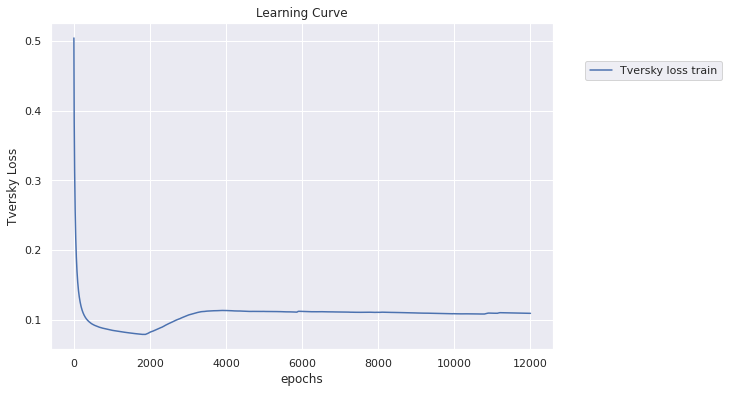

In [ ]:
yhat = savgol_filter(y1, 23, 3) 

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(xx,yhat ,label='Tversky loss train')


plt.xlabel('epochs')
plt.ylabel('Tversky Loss')
plt.title('Learning Curve')

chartBox = ax.get_position()

ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.20, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(model_path +'/loss_plot'+'.png', dpi=200,bbox_inches ='tight')            


plt.show()

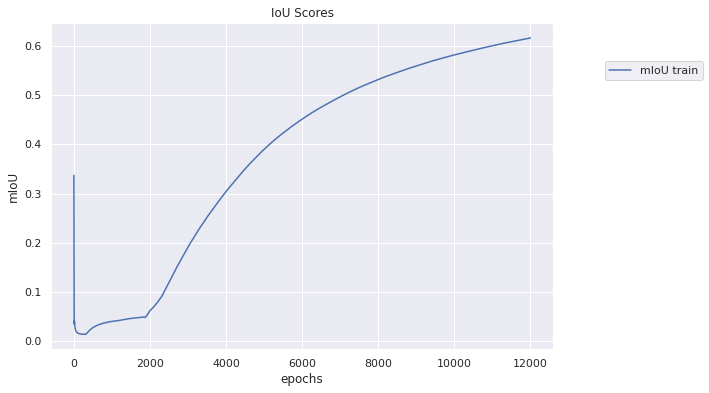

In [ ]:
yhat2 = savgol_filter(y2, 23, 3) 


fig = plt.figure()
ax = plt.subplot(111)


ax.plot(xx,yhat2 ,label='mIoU train')




plt.xlabel('epochs')
plt.ylabel('mIoU')
plt.title('IoU Scores')

chartBox = ax.get_position()

ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.20, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(model_path +'/IOU_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()

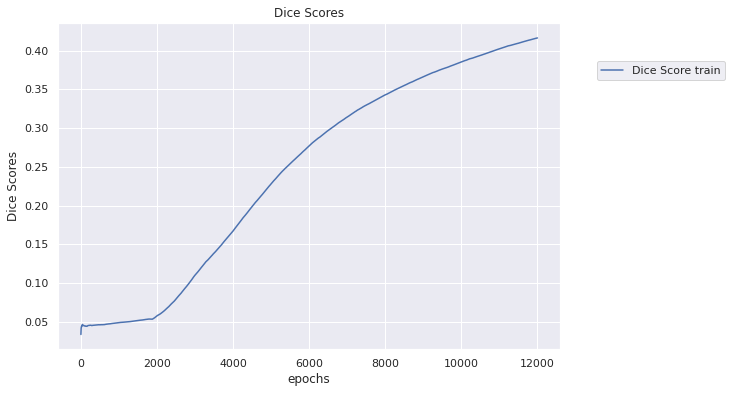

In [ ]:

yhat3 = savgol_filter(y3, 23, 3) 


fig = plt.figure()
ax = plt.subplot(111)


ax.plot(xx,yhat3 ,label='Dice Score train')

plt.xlabel('epochs')
plt.ylabel('Dice Scores')
plt.title('Dice Scores')

            
chartBox = ax.get_position()

ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.20, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(model_path +'/dice_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()

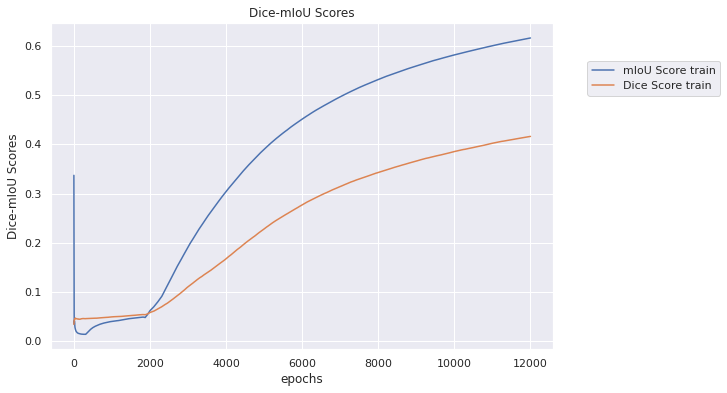

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(xx,yhat2 ,label='mIoU Score train')
ax.plot(xx,yhat3 ,label='Dice Score train')

plt.xlabel('epochs')
plt.ylabel('Dice-mIoU Scores')
plt.title('Dice-mIoU Scores')

            
chartBox = ax.get_position()

ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.20, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(model_path +'/dice+iou_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()

# Test with Intervention

In [ ]:
x_test=load('/home/zaineb/data/x_test.npy',allow_pickle=True)
y_test=load('/home/zaineb/data/y_test_fsh.npy',allow_pickle=True)
print(x_test.shape)
print(y_test.shape)

(4,)
(4,)


In [ ]:
model_path='IFFS-Net-1-FBsh-ss/'
save_path = 'IFFS-Net-1-FBsh-ss/'
SavePathTest1 = save_path + 'patientAnalysisTest-inter-30/'


In [ ]:

Data_Main_path = '/home/zaineb/data/TestData/'
Patient_names = sorted(os.listdir(Data_Main_path))

Patient_data_full_path = list(map(lambda v : str(join(Data_Main_path,v)) + '/', Patient_names))
DataTestPath = list(map(lambda s : s, Patient_data_full_path[1:5]))




# Define Mask path

Mask_Main_path = '/home/zaineb/data/Test_Mask/'
Patient_names1 = sorted(os.listdir(Mask_Main_path))

Patient_mask_full_path = list(map(lambda v : str(join(Mask_Main_path,v)) + '/', Patient_names1))
MaskTestPath = list(map(lambda s : s, Patient_mask_full_path[1:5]))

In [ ]:
def Patient_name(diretoryPathforOnePatient):
    return diretoryPathforOnePatient.split('/')[5]

In [ ]:
def DataSelection(NumberOfSubjectToConsider,TotalNumberOfPatient,DepthWindow,Data,Annotation):
    
    SubjectIndex = [np.random.randint(TotalNumberOfPatient) for i in range(NumberOfSubjectToConsider)]
    
    depthOfSelectedSubject = np.array([x_train[SubjectIndex][ind].shape[0] for ind in range(NumberOfSubjectToConsider)])


    StartinPoint = [np.random.randint(i) for i in depthOfSelectedSubject-DepthWindow ]

    ListOfConsideredIndiceis = np.array([np.arange(StartinPoint[ind],DepthWindow+StartinPoint[ind],1) for ind in range(NumberOfSubjectToConsider)])
    
    Data = np.array([Data[SubjectIndex][index][ListOfConsideredIndiceis[index]] for index in range(NumberOfSubjectToConsider)])
    
    
    Annotation = np.array([Annotation[SubjectIndex][index][ListOfConsideredIndiceis[index]] for index in range(NumberOfSubjectToConsider)])
    
    return Data,Annotation

In [ ]:
file_path = model_path + 'model--12000'
isRestor=True
with tf.Session() as sess:
    if isRestor:
        sess.run(init_o) 
        saver.restore(sess,file_path)
        print("Model restored.")
    else:
        sess.run(init_o) 
        print('Model Training from Scratch')
        
    

    Counter=0
        
    for subject in range(4):

        locals()['IOU'+str(subject)]=[]
        locals()['DICE'+str(subject)]=[]


        locals()['prediction'+str(subject)]=[] # prediction
        locals()['GT'+str(subject)]=[] # GT
        
        
        locals()['Image'+str(subject)]=[] # Images
        
        proposedPath = SavePathTest1  + str(Patient_name(DataTestPath[subject]))

        # Check if this directory exist and pass, otherwise create it
        if os.path.exists(proposedPath) is True:
            pass
        else:
            os.mkdir(proposedPath)
            
        annotationAmounts=5 #number of annotation will be feeded to model: Semi SuperVised


   

        indices_target = [xx for xx in range(0, 90)]
        j=0
        k=0
        
        # for mri we will fix it
        step=3  ## random step size at each iterationm could be fixed to 3 also
        s=0
        e=step
            
            
        for i in range(0,90): #         depthwindow=50 or we must take all the slice“200“!
            if (s<90-step-1):

                if i%annotationAmounts==0:
                    
                    next_indices_ref = indices_target[s:e]
                    print('*************Reference Update {0}**********' .format(next_indices_ref))
                    # Reference
                    x_test_ref = x_test[subject][next_indices_ref] 
                    y_test_ref = y_test[subject][next_indices_ref]
                    
                    x_test_ref=np.expand_dims(x_test_ref,0)
                    y_test_ref=np.expand_dims(y_test_ref,0)

        
                    current_output_test=sess.run(net_output_256,
                                                                  feed_dict={
                                                                      x_target:x_test_ref,
                                                                      y:y_test_ref,
                                                                      y_estimated:  y_test_ref,
                                                                      keep_prob:1.,
                                                            keep_prob_input:1.,
                                                            keep_prob_skip:1.,
                                                            keep_prob_alpha :1.0,
                                                            keep_prob_beta :1.0,
                                                            keep_prob_tp:1.
                                                           })

                    previous_estimated_y =y_test_ref
                    test_predicted_label = np.squeeze(current_output_test,0)
                    _,im1 = cv2.threshold(test_predicted_label[0][...,0],0.5,1,cv2.THRESH_BINARY)

#             

                else:

                    next_indices_target = indices_target[s:e]
                    print('Target Update {0}' .format(next_indices_target))

                    # Target
                   
                    x_test_target_current = x_test[subject][next_indices_ref] 
                    y_test_target_current = y_test[subject][next_indices_ref]
                    
                    x_test_target_current=np.expand_dims( x_test_target_current,0)
                    y_test_target_current=np.expand_dims( y_test_target_current,0)


                    
                    current_output_test  =sess.run(net_output_256,
                                                                  feed_dict={
                                                                      x_target: x_test_target_current,
                                                                      y: y_test_target_current,
                                                                      y_estimated: previous_estimated_y,
                                                                      keep_prob:1.,
                                                            keep_prob_input:1.,
                                                            keep_prob_skip:1.,
                                                            keep_prob_alpha :1.0,
                                                            keep_prob_beta :1.0,
                                                            keep_prob_tp:1.
                                                           })
                    previous_estimated_y=  current_output_test 

                    test_predicted_label = np.squeeze(current_output_test,0)

                    
                    
                    s=s+1
                    e=e+1
                    print(s,e) 
                    
                 


                
                    for j in range(test_predicted_label.shape[0]):

                            _,im1 = cv2.threshold(test_predicted_label[j][...,0],0.5,1,cv2.THRESH_BINARY)
                            im1=im1.astype('uint8')

                            try:
                                IOU = metric.jc(im1,y_test_ref[0][j,...,0])
                                DICE = metric.dc(im1,y_test_ref[0][j,...,0])


                            except Exception:
                                IOU = 1
                                DICE = 1





                            locals()['IOU'+str(subject)].append(IOU)
                            locals()['DICE'+str(subject)].append(DICE)

                            locals()['prediction'+str(subject)].append(im1)
                            locals()['GT'+str(subject)].append(y_test_ref[:,j,:,:,0])
                            locals()['Image'+str(subject)].append(x_test_ref[:,j,:,:,0])

             #Save the values       
            np.save(proposedPath+'/IOU_FBsh_'+Patient_name(DataTestPath[subject]), locals()['IOU'+str(subject)])
            np.save(proposedPath+'/DICE_FBsh_'+Patient_name(DataTestPath[subject]), locals()['DICE'+str(subject)])
          
            np.save(proposedPath+'/prediction_'+Patient_name(DataTestPath[subject]), locals()['prediction'+str(subject)])
            np.save(proposedPath+'/GT_'+Patient_name(DataTestPath[subject]), locals()['GT'+str(subject)])
            np.save(proposedPath+'/Image_'+Patient_name(DataTestPath[subject]), locals()['Image'+str(subject)])
        
        print('next subject')

        
        
        
        
    print('Done')    
        


INFO:tensorflow:Restoring parameters from IFFS-Net-1-FBsh-ss/model--12000
Model restored.
*************Reference Update [0, 1, 2]**********
Target Update [0, 1, 2]
1 4
Target Update [1, 2, 3]
2 5
Target Update [2, 3, 4]
3 6
Target Update [3, 4, 5]
4 7
*************Reference Update [4, 5, 6]**********
Target Update [4, 5, 6]
5 8
Target Update [5, 6, 7]
6 9
Target Update [6, 7, 8]
7 10
Target Update [7, 8, 9]
8 11
*************Reference Update [8, 9, 10]**********
Target Update [8, 9, 10]
9 12
Target Update [9, 10, 11]
10 13
Target Update [10, 11, 12]
11 14
Target Update [11, 12, 13]
12 15
*************Reference Update [12, 13, 14]**********
Target Update [12, 13, 14]
13 16
Target Update [13, 14, 15]
14 17
Target Update [14, 15, 16]
15 18
Target Update [15, 16, 17]
16 19
*************Reference Update [16, 17, 18]**********
Target Update [16, 17, 18]
17 20
Target Update [17, 18, 19]
18 21
Target Update [18, 19, 20]
19 22
Target Update [19, 20, 21]
20 23
*************Reference Update [20, 

Target Update [35, 36, 37]
36 39
*************Reference Update [36, 37, 38]**********
Target Update [36, 37, 38]
37 40
Target Update [37, 38, 39]
38 41
Target Update [38, 39, 40]
39 42
Target Update [39, 40, 41]
40 43
*************Reference Update [40, 41, 42]**********
Target Update [40, 41, 42]
41 44
Target Update [41, 42, 43]
42 45
Target Update [42, 43, 44]
43 46
Target Update [43, 44, 45]
44 47
*************Reference Update [44, 45, 46]**********
Target Update [44, 45, 46]
45 48
Target Update [45, 46, 47]
46 49
Target Update [46, 47, 48]
47 50
Target Update [47, 48, 49]
48 51
*************Reference Update [48, 49, 50]**********
Target Update [48, 49, 50]
49 52
Target Update [49, 50, 51]
50 53
Target Update [50, 51, 52]
51 54
Target Update [51, 52, 53]
52 55
*************Reference Update [52, 53, 54]**********
Target Update [52, 53, 54]
53 56
Target Update [53, 54, 55]
54 57
Target Update [54, 55, 56]
55 58
Target Update [55, 56, 57]
56 59
*************Reference Update [56, 57, 58]

In [ ]:
Patient_name_Test_list=['P-elite7-r','P-elite7-l','P-healthy3-r','P-healthy3-l']

No handles with labels found to put in legend.


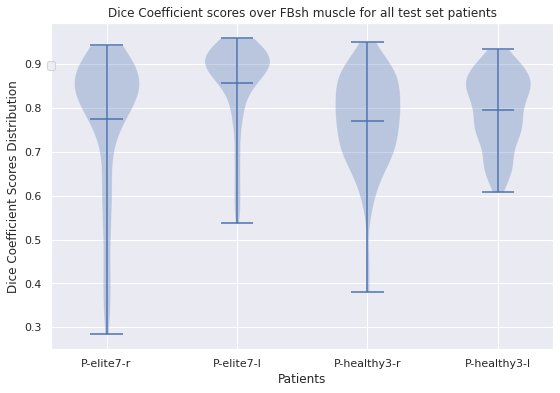

In [ ]:
SavePathValAnalysisQuantitative = SavePathTest1 

listdata=[]
meanavg=[]
for subj in range(4):
    pathRead =  SavePathTest1 + str(Patient_name(DataTestPath[subj]))+'/DICE_FBsh_'+Patient_name(DataTestPath[subj])
    data  = np.load(pathRead)
    
    listdata.append(data)
    meanavg.append(data.mean())

fig = plt.figure()
ax = plt.subplot(111)

my_xticks = list(map(lambda a: str(Patient_name(DataTestPath[a])), range(4)))
           
ax.violinplot(listdata,
                   showmeans=True,
                   showmedians=False)
    
    

# add x-tick labels
plt.setp(ax, xticks=[y+1 for y in range(len(listdata))],
         xticklabels=list(map(lambda a: Patient_name_Test_list[a], range(4))))


plt.xlabel('Patients')
plt.ylabel('Dice Coefficient Scores Distribution')
plt.title('Dice Coefficient scores over FBsh muscle for all test set patients')

chartBox = ax.get_position()

ax.set_position([0*chartBox.x0, 0*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(0, 0.9), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(SavePathValAnalysisQuantitative +'/dice_coef_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()

        

No handles with labels found to put in legend.


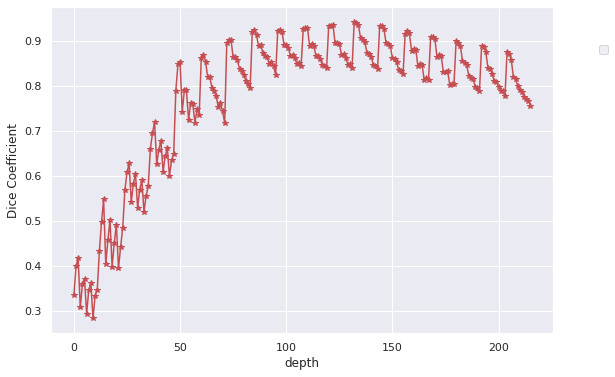

No handles with labels found to put in legend.


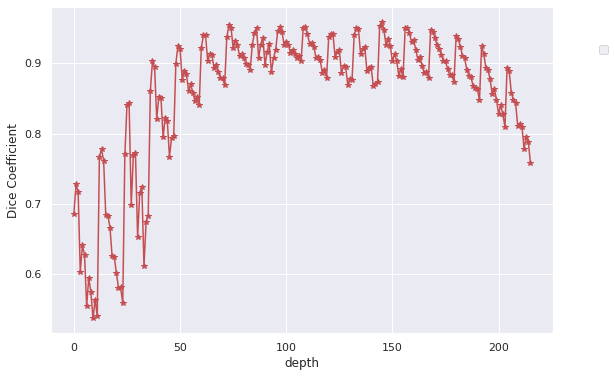

No handles with labels found to put in legend.


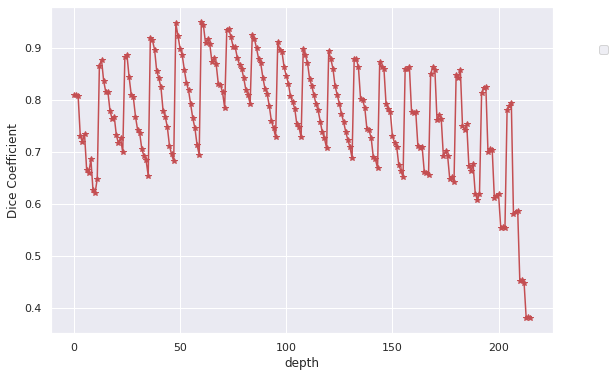

No handles with labels found to put in legend.


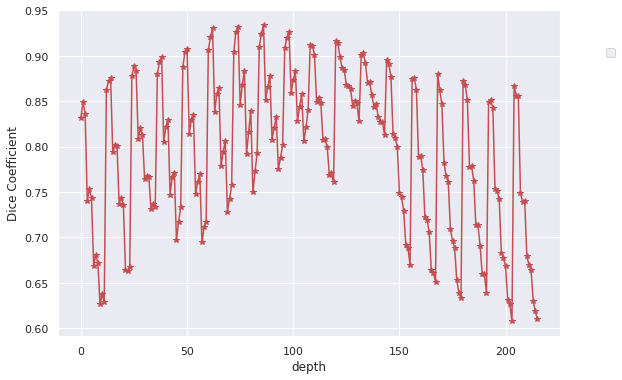

In [ ]:
# Violin Plot trial

for subj in range(len(DataTestPath)):
    pathRead = SavePathTest1+ str(Patient_name(DataTestPath[subj]))+'/DICE_FBsh_'+Patient_name(DataTestPath[subj])
    y1  = np.load(pathRead)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(y1 ,'r-*')
    plt.xlabel('depth')
    plt.ylabel('Dice Coefficient')
    chartBox = ax.get_position()
    ax.set_position([0*chartBox.x0, 0*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
    ax.legend(loc='upper center', bbox_to_anchor=(1.10, 0.90), shadow=False, ncol=1)
    fig1 = plt.gcf()
    plt.show()
    proposedPath = SavePathTest1 + str(Patient_name(DataTestPath[subj]))

No handles with labels found to put in legend.


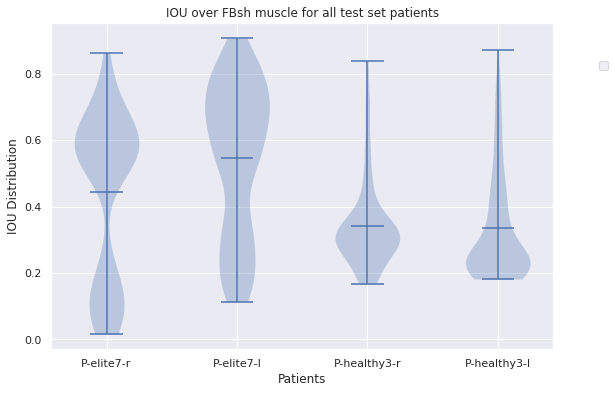

In [ ]:
SavePathValAnalysisQuantitative =  SavePathTest

listdata=[]
meanavg=[]
for subj in range(4):
    pathRead = SavePathTest + str(Patient_name(DataTestPath[subj]))+'/IOU_FBsh_'+Patient_name(DataTestPath[subj])
    data  = np.load(pathRead)
    
    listdata.append(data)
    meanavg.append(data.mean())

fig = plt.figure()
ax = plt.subplot(111)

my_xticks = list(map(lambda a: str(Patient_name(DataTestPath[a])), range(4)))
           
ax.violinplot(listdata,
                   showmeans=True,
                   showmedians=False)
    
    

# add x-tick labels
plt.setp(ax, xticks=[y+1 for y in range(len(listdata))],
         xticklabels=list(map(lambda a: Patient_name_Test_list[a], range(4))))


plt.xlabel('Patients')
plt.ylabel('IOU Distribution')
plt.title('IOU over FBsh muscle for all test set patients')

chartBox = ax.get_position()


ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.10, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(SavePathValAnalysisQuantitative +'/iou_coef_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()


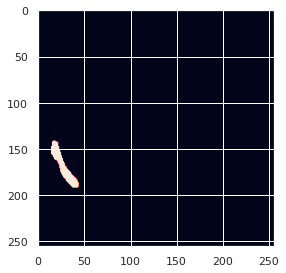

In [ ]:
e7l=load('/home/zaineb/sources/IFFS-Net-1-FBsh-ss/patientAnalysisTest/e7-l.npy/GT_e7-l.npy')

fig=plt.figure(figsize=(50,50))
for num,each_slice in enumerate(e7l[50]):
    y=fig.add_subplot(1,10,num+1)
    y.imshow(each_slice)
plt.show()

In [ ]:
e7l.shape

(216, 1, 256, 256)

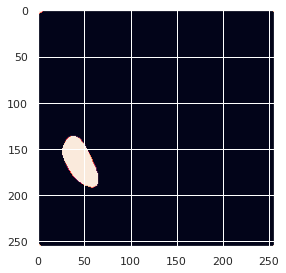

In [ ]:
e7lp=load('/home/zaineb/sources/IFFS-Net-1-FBsh-ss/patientAnalysisTest/e7-l.npy/prediction_e7-l.npy')

fig=plt.figure(figsize=(50,50))
for num,each_slice in enumerate(e7lp[50:51]):
    y=fig.add_subplot(1,10,num+1)
    y.imshow(each_slice)
plt.show()

# withoutinterventionter

In [ ]:
model_path='IFSS-Net-1-FBsh-FS/'
save_path = 'IFSS-Net-1-FBsh-FS/'
SavePathTest = save_path + 'patientAnalysisTest/'

In [ ]:
file_path = model_path + 'model--6000-6000'
isRestor=True
with tf.Session() as sess:
    if isRestor:
        sess.run(init_o) 
        saver.restore(sess,file_path)
        print("Model restored.")
    else:
        sess.run(init_o) 
        print('Model Training from Scratch')
        
    

    Counter=0

        
        
    for subject in range(4):

        locals()['IOU'+str(subject)]=[]
        locals()['DICE'+str(subject)]=[]


        locals()['prediction'+str(subject)]=[] # prediction
        locals()['GT'+str(subject)]=[] # GT
        
        locals()['Image'+str(subject)]=[] # Images
        
        proposedPath = SavePathTest + str(Patient_name(DataTestPath[subject]))

        # Check if this directory exist and pass, otherwise create it
        if os.path.exists(proposedPath) is True:
            pass
        else:
            os.mkdir(proposedPath)
            
            
        xtest=np.expand_dims(x_test[subject],0)
        ytest=np.expand_dims(y_test[subject],0)
        
        current_output_test  =sess.run(net_output_256,
                                                      feed_dict={
                                                          x_target: xtest,
                                                          y_estimated: ytest,

                                                          keep_prob:1.,
                                                keep_prob_input:1.,
                                                keep_prob_skip:1.,
                                                keep_prob_alpha :1.0,
                                                keep_prob_beta :1.0,
                                                keep_prob_tp:1.
                                               })
        
        test_predicted_label = np.squeeze(current_output_test,0)
        xtest = np.squeeze(xtest,0)
        ytest=y_test[subject]

        for j in range(test_predicted_label.shape[0]):
            
            _,im1 = cv2.threshold(test_predicted_label[j][...,0],0.5,1,cv2.THRESH_BINARY)
            im1=im1.astype('uint8')
            
            try:
                IOU = metric.jc(im1, ytest[j][...,0])
                DICE = metric.dc(im1,ytest[j][...,0])
             
                    
            except Exception:
                IOU = 1
                DICE = 1
             

        
        

            locals()['IOU'+str(subject)].append(IOU)
            locals()['DICE'+str(subject)].append(DICE)
          
            locals()['prediction'+str(subject)].append(im1)
            locals()['GT'+str(subject)].append(ytest[j][...,0])
            locals()['Image'+str(subject)].append(xtest[j][...,0])

             #Save the values       
            np.save(proposedPath+'/IOU_FBsh_'+Patient_name(DataTestPath[subject]), locals()['IOU'+str(subject)])
            np.save(proposedPath+'/DICE_FBsh_'+Patient_name(DataTestPath[subject]), locals()['DICE'+str(subject)])
          
            np.save(proposedPath+'/prediction_'+Patient_name(DataTestPath[subject]), locals()['prediction'+str(subject)])
            np.save(proposedPath+'/GT_'+Patient_name(DataTestPath[subject]), locals()['GT'+str(subject)])
            np.save(proposedPath+'/Image_'+Patient_name(DataTestPath[subject]), locals()['Image'+str(subject)])
        
        print('next subject')

        
        
        
        
    print('Done')    
        


INFO:tensorflow:Restoring parameters from IFSS-Net-1-FBsh-FS/model--6000-6000
Model restored.
next subject
next subject
next subject
next subject
Done


In [ ]:
Patient_name_Test_list=['P-elite7-r','P-elite7-l','P-healthy3-r','P-healthy3-l']

No handles with labels found to put in legend.


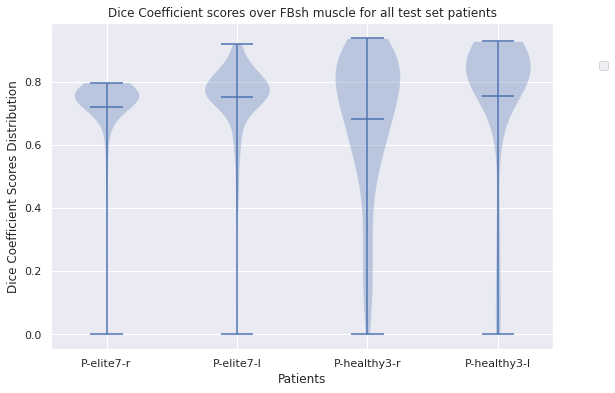

In [ ]:
SavePathValAnalysisQuantitative =SavePathTest 

listdata=[]
meanavg=[]
for subj in range(4):
    pathRead = SavePathTest + str(Patient_name(DataTestPath[subj]))+'/DICE_FBsh_'+Patient_name(DataTestPath[subj])
    data  = np.load(pathRead)
    
    listdata.append(data)
    meanavg.append(data.mean())

fig = plt.figure()
ax = plt.subplot(111)

my_xticks = list(map(lambda a: str(Patient_name(DataTestPath[a])), range(4)))
           
ax.violinplot(listdata,
                   showmeans=True,
                   showmedians=False)
    
    

# add x-tick labels
plt.setp(ax, xticks=[y+1 for y in range(len(listdata))],
         xticklabels=list(map(lambda a: Patient_name_Test_list[a], range(4))))


plt.xlabel('Patients')
plt.ylabel('Dice Coefficient Scores Distribution')
plt.title('Dice Coefficient scores over FBsh muscle for all test set patients')

chartBox = ax.get_position()

ax.set_position([0*chartBox.x0, 0*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.10, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(SavePathValAnalysisQuantitative +'/dice_coef_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()


        

No handles with labels found to put in legend.


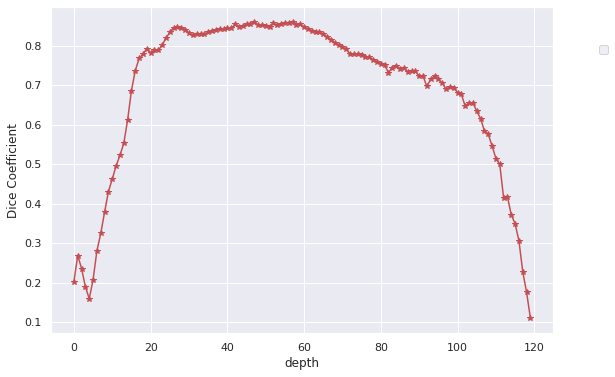

No handles with labels found to put in legend.


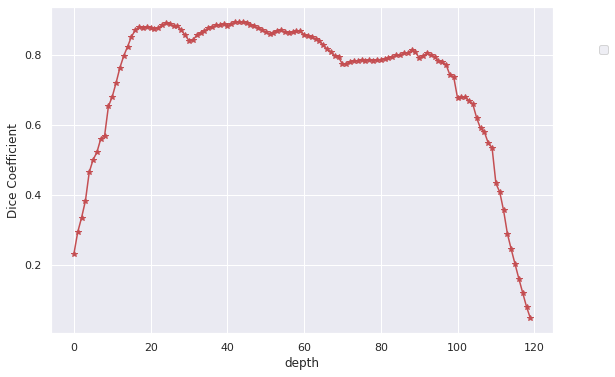

No handles with labels found to put in legend.


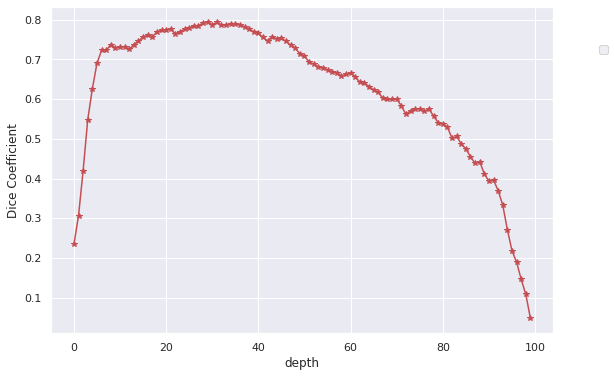

No handles with labels found to put in legend.


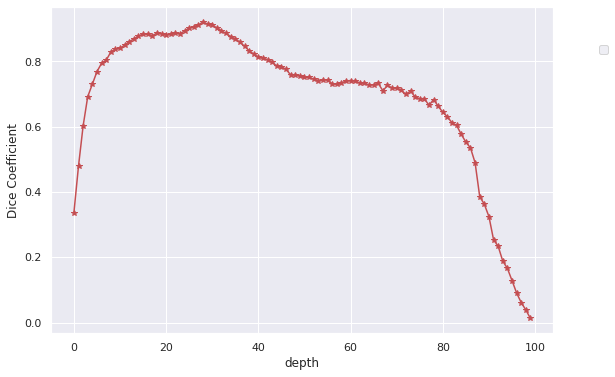

In [ ]:
# Violin Plot trial
SavePathVal =SavePathTest 
SavePathValAnalysisQuantitative = save_path + 'QAnalysisVal/'
for subj in range(len(DataTestPath)):
    pathRead = SavePathVal + str(Patient_name(DataTestPath[subj]))+'/DICE_FBsh_'+Patient_name(DataTestPath[subj])
    y1  = np.load(pathRead)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(y1 ,'r-*')
    plt.xlabel('depth')
    plt.ylabel('Dice Coefficient')
    chartBox = ax.get_position()
    ax.set_position([0*chartBox.x0, 0*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
    ax.legend(loc='upper center', bbox_to_anchor=(1.10, 0.90), shadow=False, ncol=1)
    fig1 = plt.gcf()
    plt.show()
    proposedPath = SavePathVal + str(Patient_name(DataTestPath[subj]))
    fig1.savefig(proposedPath +'/Dice_fsh_'+str(Patient_name(DataTestPath[subj]))+'.png', dpi=200,bbox_inches ='tight')    



No handles with labels found to put in legend.


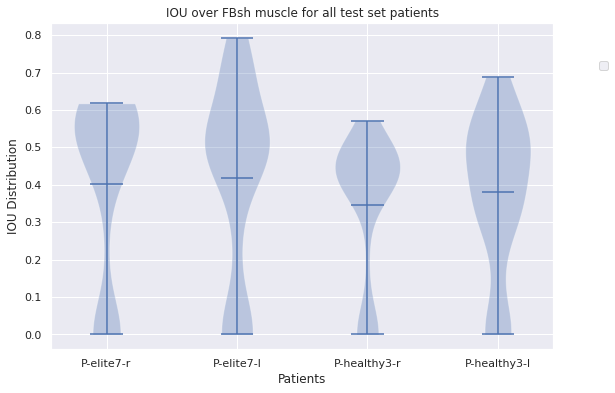

In [ ]:
SavePathValAnalysisQuantitative = SavePathTest 

listdata=[]
meanavg=[]
for subj in range(4):
    pathRead = SavePathTest + str(Patient_name(DataTestPath[subj]))+'/IOU_FBsh_'+Patient_name(DataTestPath[subj])
    data  = np.load(pathRead)
    
    listdata.append(data)
    meanavg.append(data.mean())

fig = plt.figure()
ax = plt.subplot(111)

my_xticks = list(map(lambda a: str(Patient_name(DataTestPath[a])), range(4)))
           
ax.violinplot(listdata,
                   showmeans=True,
                   showmedians=False)
    
    

# add x-tick labels
plt.setp(ax, xticks=[y+1 for y in range(len(listdata))],
         xticklabels=list(map(lambda a: Patient_name_Test_list[a], range(4))))


plt.xlabel('Patients')
plt.ylabel('IOU Distribution')
plt.title('IOU over FBsh muscle for all test set patients')

chartBox = ax.get_position()


ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.10, 0.90), shadow=False, ncol=1)

fig1 = plt.gcf()
fig1.savefig(SavePathValAnalysisQuantitative +'/IOU_plot'+'.png', dpi=200,bbox_inches ='tight')            

plt.show()


In [ ]:
d1=load('/home/zaineb/sources/IFFS-Net-flh-1-ss/patientAnalysisTest-no-intervention/e7-l.npy/IOU_FBsh_e7-l.npy')
d2=load('/home/zaineb/sources/IFFS-Net-flh-1-ss/patientAnalysisTest-no-intervention/e7-r.npy/IOU_FBsh_e7-r.npy')
d3=load('/home/zaineb/sources/IFFS-Net-flh-1-ss/patientAnalysisTest-no-intervention/h3-l.npy/IOU_FBsh_h3-l.npy')
d4=load('/home/zaineb/sources/IFFS-Net-flh-1-ss/patientAnalysisTest-no-intervention/h3-r.npy/IOU_FBsh_h3-r.npy')

In [ ]:
(d1.mean()+d2.mean()+d3.mean()+d4.mean())/4

0.38625837045917527

In [ ]:
model_path = '/home/zaineb/sources/IFFS-Net-1-FBsh-ss/'


In [ ]:
x_test=load('/home/zaineb/data/x_test.npy',allow_pickle=True)
y_test=load('/home/zaineb/data/y_test_fsh.npy',allow_pickle=True)
print(x_test.shape)
print(y_test.shape)

(4,)
(4,)


In [ ]:
file_path = model_path + 'model--12000'
isRestor=True
with tf.Session() as sess:
    if isRestor:
        sess.run(init_o) 
        saver.restore(sess,file_path)
        print("Model restored.")
    else:
        sess.run(init_o) 
        print('Model Training from Scratch')
        

            
    xtest_mc=np.expand_dims(x_test[0],0)
    ytest=np.expand_dims(y_test[0],0)

    Mclist=[]
    
    for sample in range(100): 
            
            current_output_mc=sess.run(net_output_256,
                                                          feed_dict={
                                                              x_target: xtest_mc,
                                                              y_estimated: ytest,
  


                                                              keep_prob:0.9,
                                                    keep_prob_input:0.9,
                                                    keep_prob_skip:0.9,
                                                    keep_prob_alpha :1.,
                                                    keep_prob_beta :1.,
                                                    keep_prob_tp:1.
                                                   })
            print(current_output_mc.shape)
            
    
            Mclist.append(current_output_mc)
        
        
    Mclist= np.stack(Mclist)
    Mclist=np.squeeze(Mclist,1)    
    print('Done')    
        
        
        
        
        

       

INFO:tensorflow:Restoring parameters from /home/zaineb/sources/IFFS-Net-flh-1-ss/model--12000
Model restored.
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 256, 256, 2)
(1, 120, 2

In [ ]:
meanPrediction= np.mean(  Mclist,0)
uncertainity= np.std(Mclist,0)


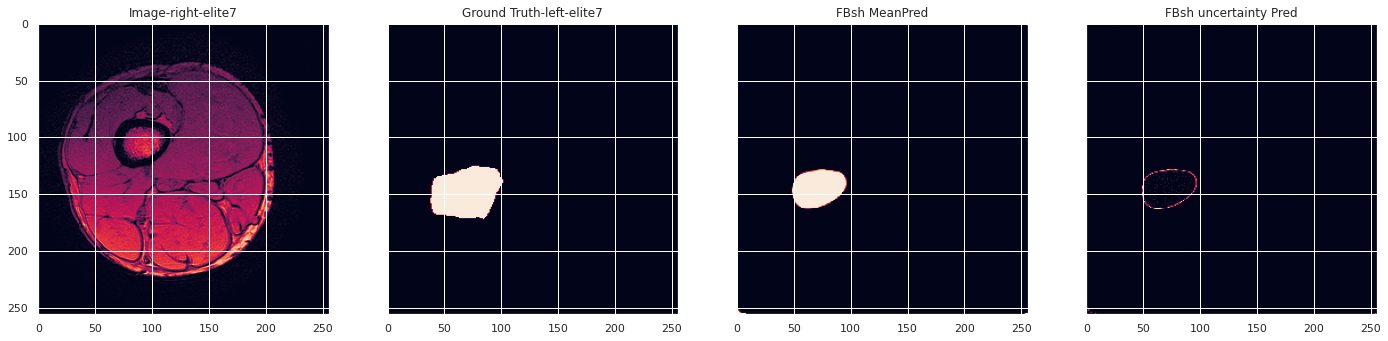

In [ ]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(24,8))

ax[0].imshow(x_test[0][50] )
ax[1].imshow(y_test[0][50,...,0] )
ax[2].imshow(meanPrediction[50,...,0] )
ax[3].imshow(uncertainity[50,...,0])

ax[0].set_title('Image-right-elite7')
ax[1].set_title('Ground Truth-left-elite7')
ax[2].set_title('FBsh MeanPred')
ax[3].set_title('FBsh uncertainty Pred')

fig.savefig(SavePathTest +'/u-fsh-50'+'.png', dpi=200,bbox_inches ='tight')            


plt.show()

In [ ]:
# Binarize the uncertainty map o force it to contain a value either 0 or 1
BI =np.array([cv2.threshold(uncertainity[j][...,0],0.4,1,cv2.THRESH_BINARY) [1]for j in range(uncertainity.shape[0])])
# convert to cm H=spacing between slices
H =2*0.1
spacing = 0.74254572391510*0.1* 0.74254572391510*0.1 # spacing between pixels cm2
VolumeAccumulation_uncertainty=[]
for i in range(BI.shape[0]-1):
    S1 =np.sum(BI[i])*spacing
    S2 =np.sum(BI[i+1])*spacing
    v=(1/3)*H*(S1 + S2 + np.sqrt(S1*S2))
    VolumeAccumulation_uncertainty.append(v)
print( np.sum(VolumeAccumulation_uncertainty))

5.147223712887159
